In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/2021-ai-w10-p1/2021-ai-w10-p1/train.csv
/kaggle/input/2021-ai-w10-p1/2021-ai-w10-p1/test.csv
/kaggle/input/2021-ai-w10-p1/2021-ai-w10-p1/sample_submit.csv


In [2]:
import torch
import torch.nn.init
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import models

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [4]:
train=pd.read_csv('/kaggle/input/2021-ai-w10-p1/2021-ai-w10-p1/train.csv')
test=pd.read_csv('/kaggle/input/2021-ai-w10-p1/2021-ai-w10-p1/test.csv')
submit=pd.read_csv('/kaggle/input/2021-ai-w10-p1/2021-ai-w10-p1/sample_submit.csv')
train

,Category,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59997,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59998,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
test

,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
xtrain=train.drop('Category',axis=1)
ytrain=train.Category

In [7]:
xt=test
yt=submit.Category

In [8]:
transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3,1,1)),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [9]:
class MNISTDataset(Dataset):
    def __init__(self, images, labels=None, transforms=None):
        self.X = images
        self.y = labels
        self.transforms = transforms
         
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):

        data = self.X.iloc[i, :]
        data = np.asarray(data).astype(np.uint8).reshape(28, 28, 1)
        
        if self.transforms:
            data = self.transforms(data)
            
        if self.y is not None:
            return (data, self.y[i])
        else:
            return data


train_data = MNISTDataset(xtrain, ytrain, transform)
test_data = MNISTDataset(xt, yt, transform)

# dataloaders
train_loader = DataLoader(train_data, batch_size=100, shuffle=True)
test_loader = DataLoader(test_data, batch_size=100, shuffle=False)

In [10]:
resnet50=models.resnet50(pretrained=True)
resnet50.to(device)

print(resnet50)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
resnet50.fc.out_features = 10

In [12]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(resnet50.parameters(), lr=0.001, momentum=0.9)

In [13]:
def train(model, train_dataloader):
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    for i, data in enumerate(train_dataloader):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
#         loss.requires_grad = True
        train_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
    train_loss = train_running_loss/len(train_dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(train_dataloader.dataset)
 
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}')
    
    return train_loss, train_accuracy

In [14]:
train_loss , train_accuracy = [], []
for epoch in range(5):
    train_epoch_loss, train_epoch_accuracy = train(resnet50, train_loader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
print(train_accuracy)

Train Loss: 0.0020, Train Acc: 96.35
Train Loss: 0.0002, Train Acc: 99.59
Train Loss: 0.0001, Train Acc: 99.82
Train Loss: 0.0000, Train Acc: 99.94
Train Loss: 0.0000, Train Acc: 99.96
[96.35, 99.59166666666667, 99.82166666666667, 99.93833333333333, 99.96333333333334]


In [15]:
predictions = []

with torch.no_grad():
    resnet50.eval()
    predictions=[]
    for int, data in enumerate(test_loader):
        data, target = data[0].to(device), data[1].to(device)
        output = resnet50(data)
        _, preds = torch.max(output.data, 1)
        predictions.append(preds.cpu().numpy())

In [16]:
p=np.concatenate(predictions).reshape(-1,1)
print(p.shape)
print(p)

(10000, 1)
[[6]
 [1]
 [0]
 ...
 [2]
 [8]
 [3]]


In [17]:
submit.Category=p
submit

,Id,Category
0,0,6
1,1,1
2,2,0
3,3,0
4,4,9
...,...,...
9995,9995,3
9996,9996,7
9997,9997,2
9998,9998,8


(28, 28)


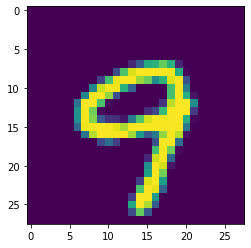

In [18]:
tmp=test.iloc[4,:].values.reshape(28,28)
print(tmp.shape)
import matplotlib.pyplot as plt
plt.imshow(tmp.reshape(28,28))

In [19]:
submit.to_csv('submission.csv',index=False,mode='w')